# 🚀 Detecting Fraudulent Transactions with Scikit-Learn 🚀

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fraud-detection-transactions-dataset/synthetic_fraud_dataset.csv


# 📚 Importing libraries 📚

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')

from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_predict

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# 📥 Dataset Loading 📥

In [3]:
df=pd.read_csv("/kaggle/input/fraud-detection-transactions-dataset/synthetic_fraud_dataset.csv")

# 🗂️ Dataset Overview 🗂️

In [4]:
print('DATASET SHAPE:')
print(f"{df.shape[0]} rows")
print(f"{df.shape[1]} columns")

DATASET SHAPE:
50000 rows
21 columns


In [5]:
df.head()

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,...,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label
0,TXN_33553,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,...,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0
1,TXN_9427,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,...,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1
2,TXN_199,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0,...,14,50.01,4,Visa,226,1909.29,Biometric,0.8400,0,1
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,Clothing,0,...,8,182.48,4,Visa,76,1311.86,OTP,0.7935,0,1
4,TXN_39489,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,Electronics,0,...,14,328.69,4,Mastercard,140,966.98,Password,0.3819,1,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_ID                50000 non-null  object 
 1   User_ID                       50000 non-null  object 
 2   Transaction_Amount            50000 non-null  float64
 3   Transaction_Type              50000 non-null  object 
 4   Timestamp                     50000 non-null  object 
 5   Account_Balance               50000 non-null  float64
 6   Device_Type                   50000 non-null  object 
 7   Location                      50000 non-null  object 
 8   Merchant_Category             50000 non-null  object 
 9   IP_Address_Flag               50000 non-null  int64  
 10  Previous_Fraudulent_Activity  50000 non-null  int64  
 11  Daily_Transaction_Count       50000 non-null  int64  
 12  Avg_Transaction_Amount_7d     50000 non-null  float64
 13  F

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Transaction_Amount,50000.0,99.411012,98.687292,0.0000,28.6775,69.66000,138.852500,1174.14
Account_Balance,50000.0,50294.065981,28760.458557,500.4800,25355.9950,50384.43000,75115.135000,99998.31
IP_Address_Flag,50000.0,0.050200,0.218360,0.0000,0.0000,0.00000,0.000000,1.00
Previous_Fraudulent_Activity,50000.0,0.098400,0.297858,0.0000,0.0000,0.00000,0.000000,1.00
Daily_Transaction_Count,50000.0,7.485240,4.039637,1.0000,4.0000,7.00000,11.000000,14.00
Avg_Transaction_Amount_7d,50000.0,255.271924,141.382279,10.0000,132.0875,256.08500,378.032500,500.00
Failed_Transaction_Count_7d,50000.0,2.003540,1.414273,0.0000,1.0000,2.00000,3.000000,4.00
Card_Age,50000.0,119.999940,68.985817,1.0000,60.0000,120.00000,180.000000,239.00
Transaction_Distance,50000.0,2499.164155,1442.013834,0.2500,1256.4975,2490.78500,3746.395000,4999.93
Risk_Score,50000.0,0.501556,0.287774,0.0001,0.2540,0.50225,0.749525,1.00


In [8]:
#We can see that there are no missing values so there is no need to visualize it 

# 📈 Numerical Features 📈

In [9]:
num_cols=df.select_dtypes(include='number').columns.tolist()
num_cols

['Transaction_Amount',
 'Account_Balance',
 'IP_Address_Flag',
 'Previous_Fraudulent_Activity',
 'Daily_Transaction_Count',
 'Avg_Transaction_Amount_7d',
 'Failed_Transaction_Count_7d',
 'Card_Age',
 'Transaction_Distance',
 'Risk_Score',
 'Is_Weekend',
 'Fraud_Label']

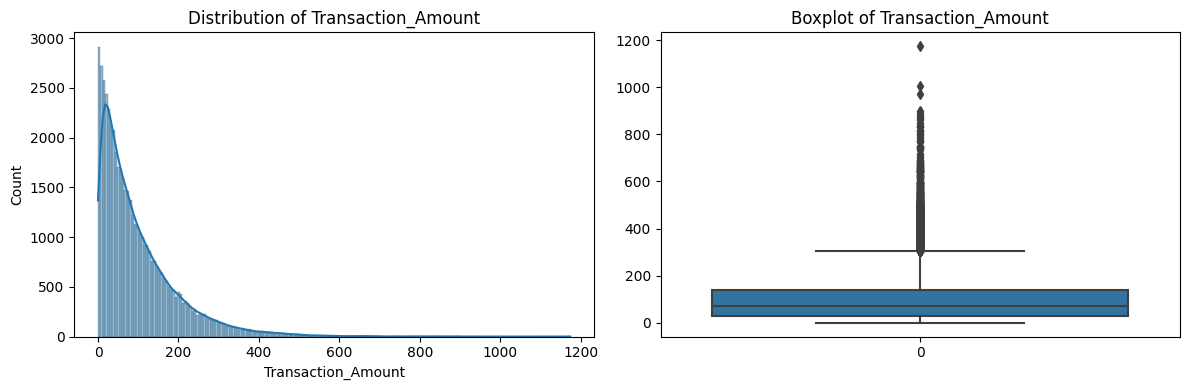

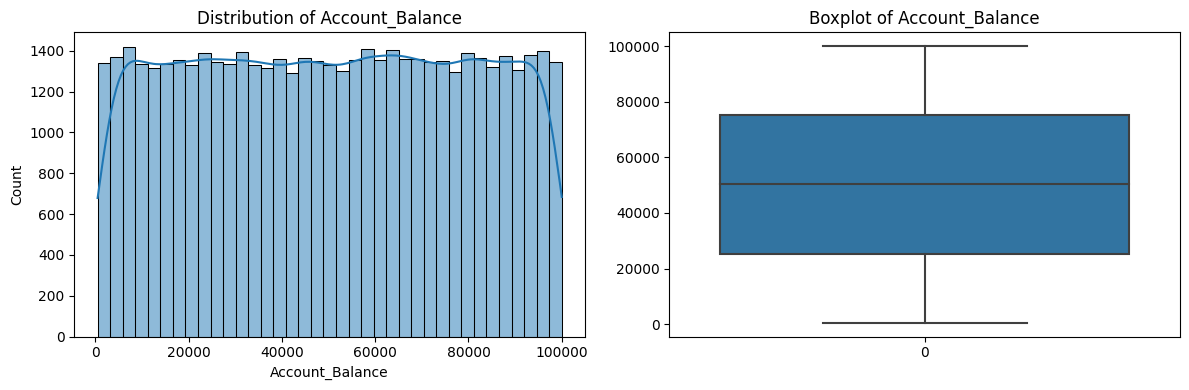

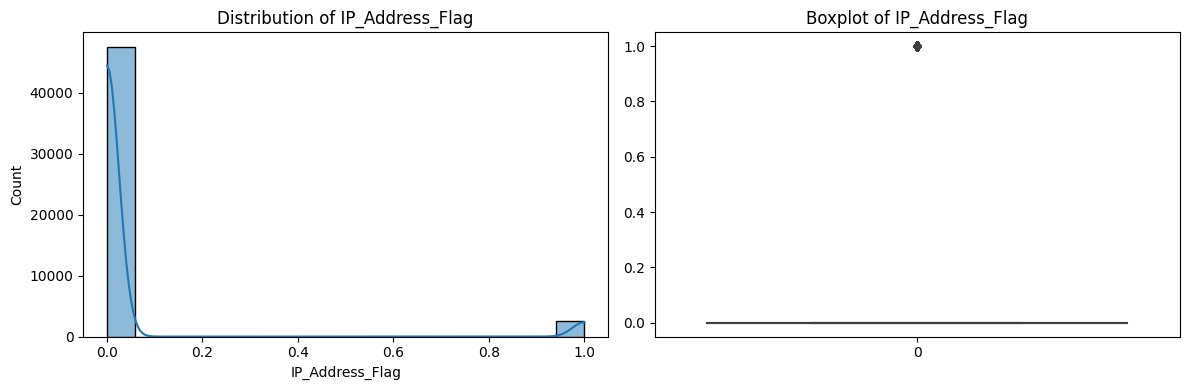

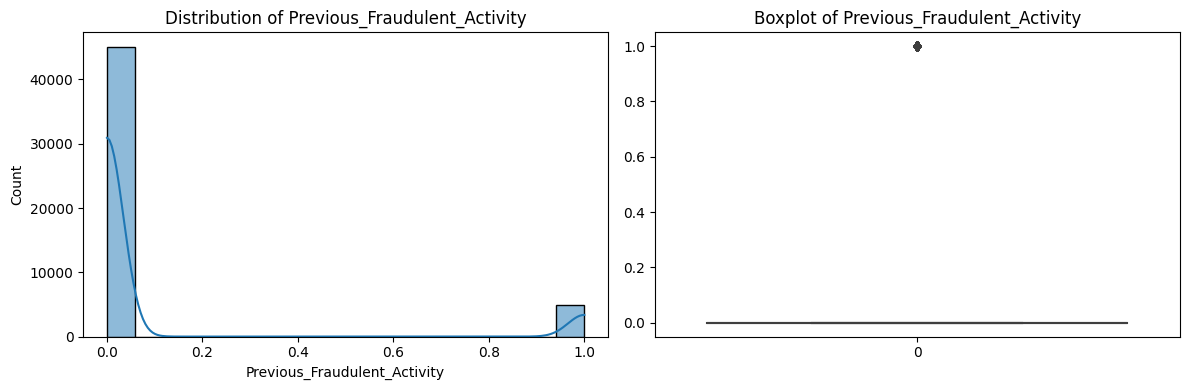

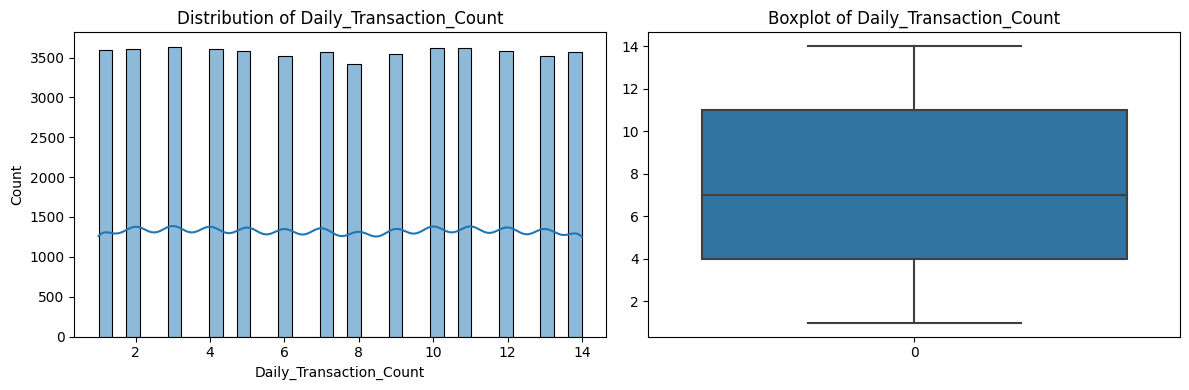

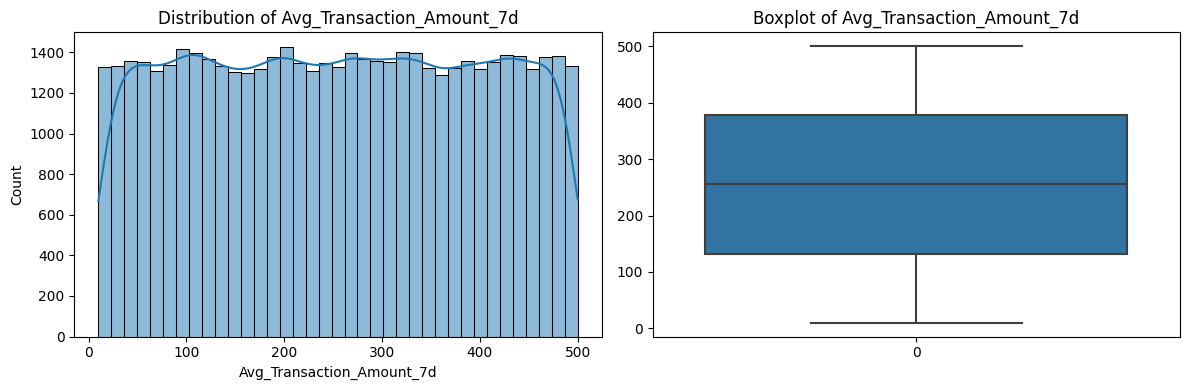

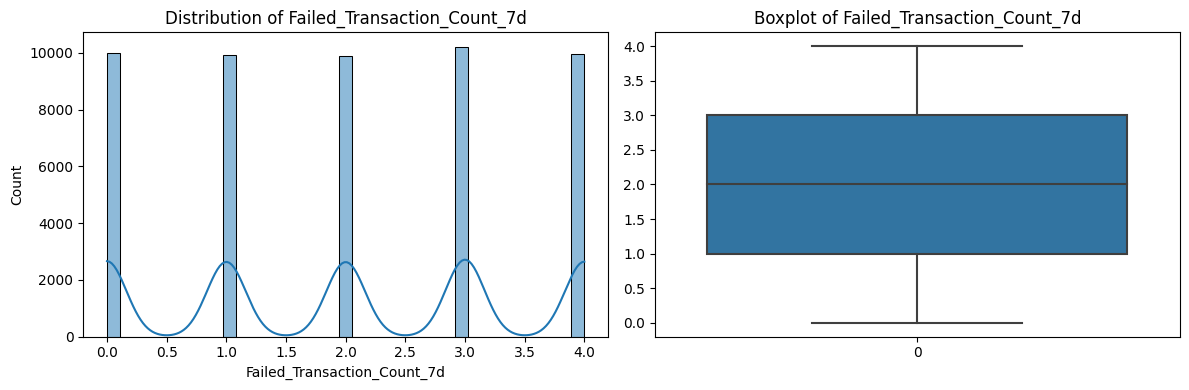

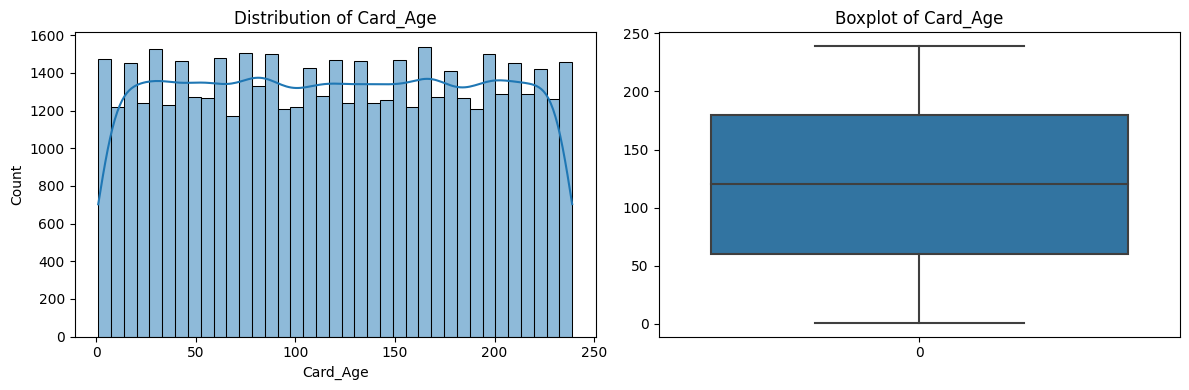

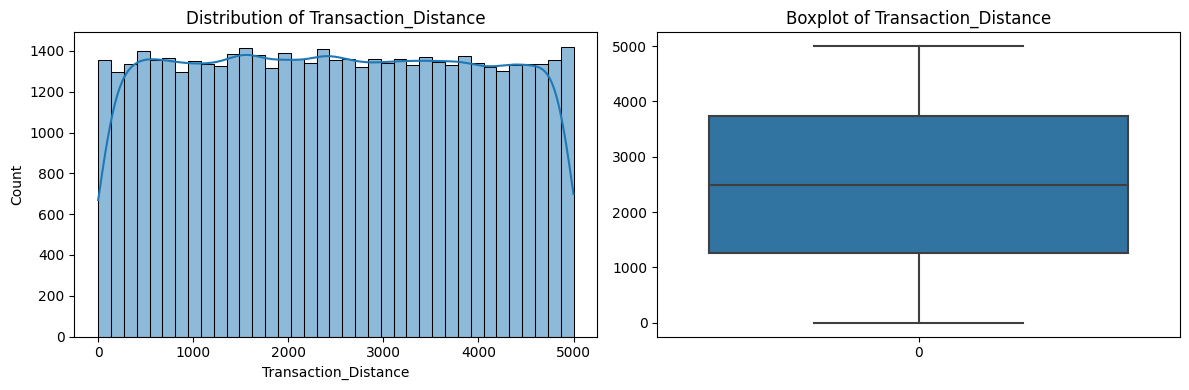

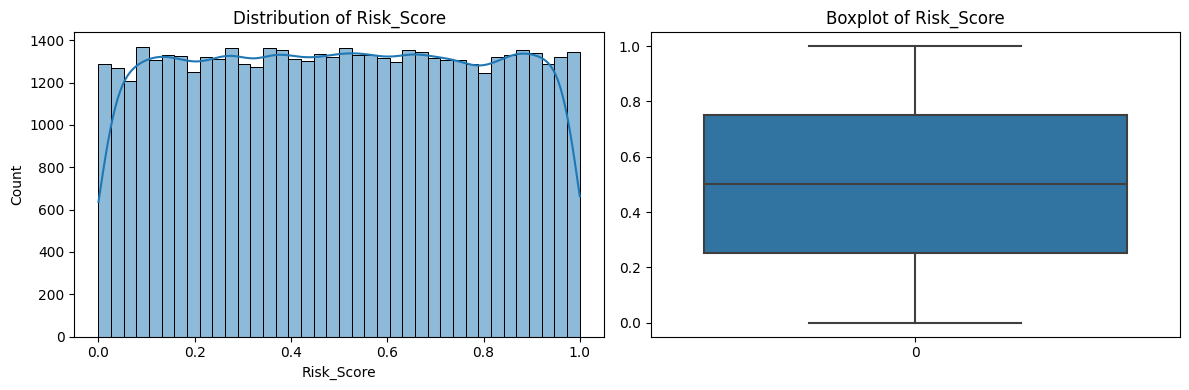

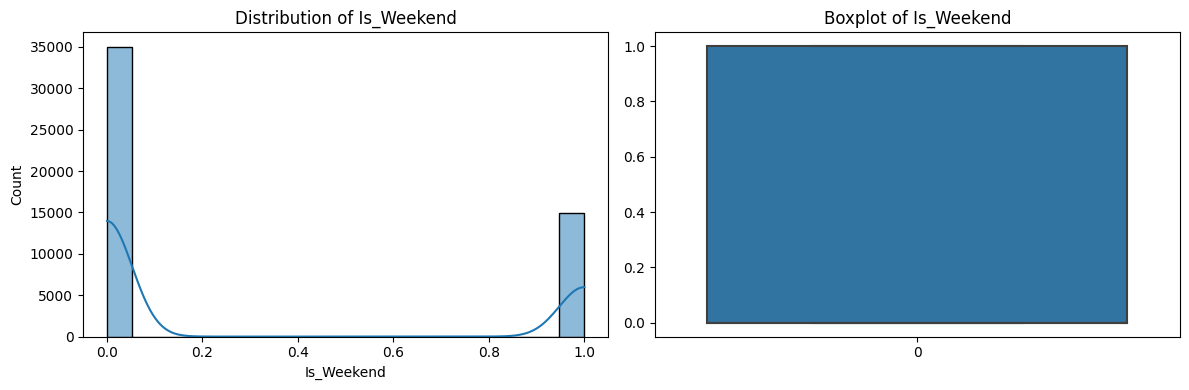

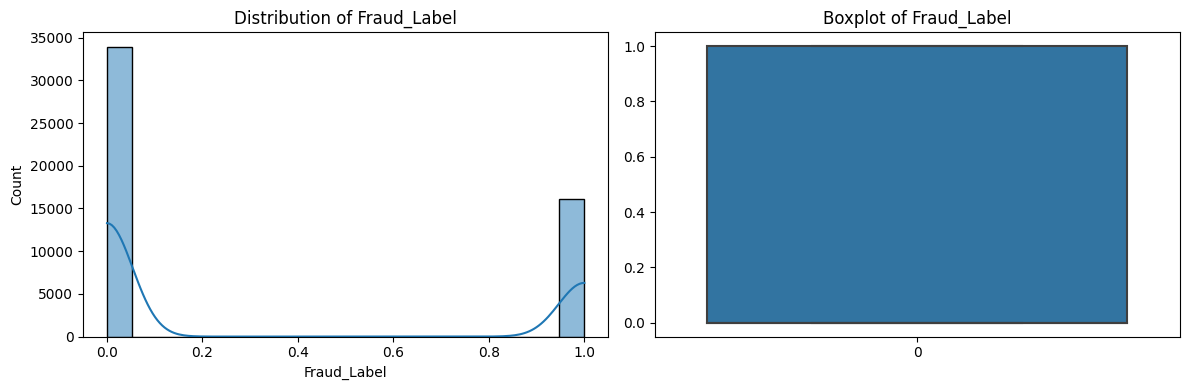

In [10]:
for col in num_cols:
    fig, axes = plt.subplots(1,2,figsize=(12,4))
    axes[0].set_title(f"Distribution of {col}")
    axes[1].set_title(f"Boxplot of {col}")
    sns.histplot(df[col], kde=True, ax=axes[0])
    sns.boxplot(df[col], ax=axes[1])
    plt.tight_layout()
    plt.show()

In [11]:
binary_cols=['Is_Weekend', 'Previous_Fraudulent_Activity', 'IP_Address_Flag', 'Fraud_Label']
num_cols=[x for x in num_cols if x not in binary_cols]
num_cols

['Transaction_Amount',
 'Account_Balance',
 'Daily_Transaction_Count',
 'Avg_Transaction_Amount_7d',
 'Failed_Transaction_Count_7d',
 'Card_Age',
 'Transaction_Distance',
 'Risk_Score']

# 🔢 Binary Features 🔢

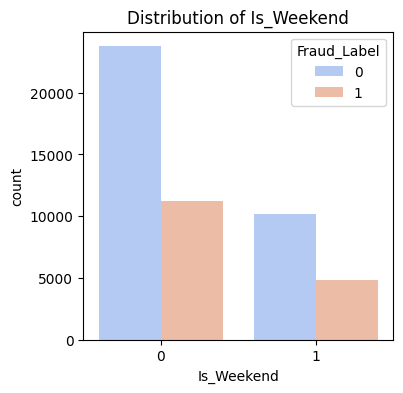

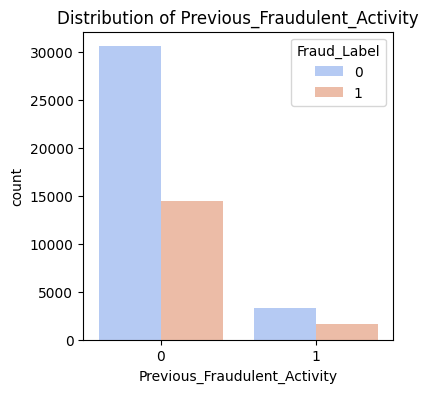

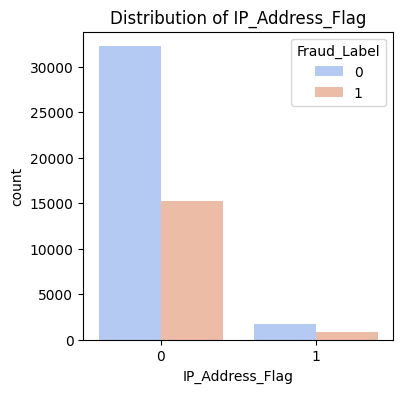

In [12]:
for col in binary_cols[:-1]:
    plt.figure(figsize=(4,4))
    plt.title(f"Distribution of {col}")
    sns.countplot(x=col, data=df, hue=df['Fraud_Label'], palette='coolwarm')
    plt.show()


In [13]:
for col in binary_cols:
    print("*"*50)
    print(df[col].value_counts())

**************************************************
Is_Weekend
0    35018
1    14982
Name: count, dtype: int64
**************************************************
Previous_Fraudulent_Activity
0    45080
1     4920
Name: count, dtype: int64
**************************************************
IP_Address_Flag
0    47490
1     2510
Name: count, dtype: int64
**************************************************
Fraud_Label
0    33933
1    16067
Name: count, dtype: int64


# 🏷️ Category Features 🏷️

In [14]:
cat_cols=[x for x in df.columns if x not in num_cols and x not in binary_cols]
cat_cols

['Transaction_ID',
 'User_ID',
 'Transaction_Type',
 'Timestamp',
 'Device_Type',
 'Location',
 'Merchant_Category',
 'Card_Type',
 'Authentication_Method']

In [15]:
#Lets remove Transaction_ID, User_ID because they are unique and dont include any useful information
#Also we wanna remove timestamp from this list, its not category column in this form, but we will for sure handle it
cat_cols.remove('Transaction_ID')
cat_cols.remove('User_ID')
cat_cols.remove('Timestamp')
cat_cols

['Transaction_Type',
 'Device_Type',
 'Location',
 'Merchant_Category',
 'Card_Type',
 'Authentication_Method']

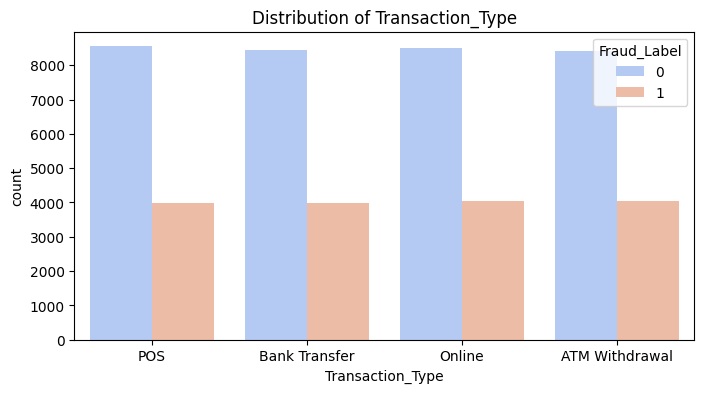

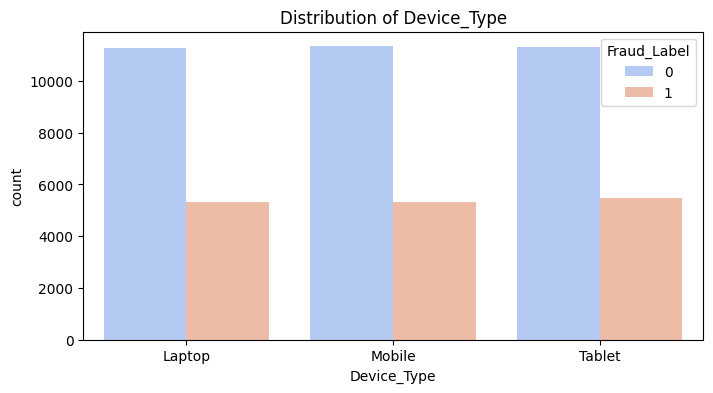

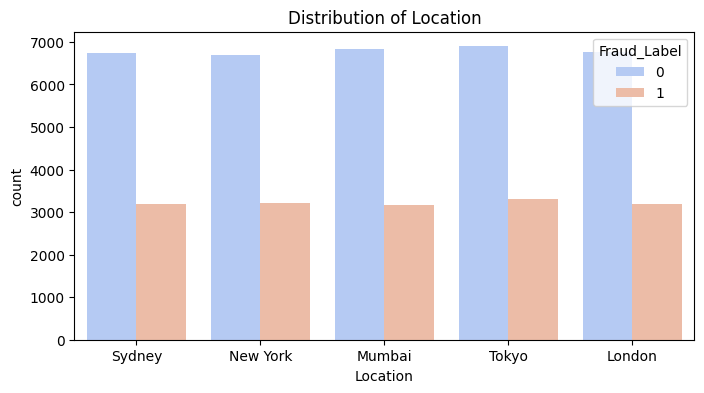

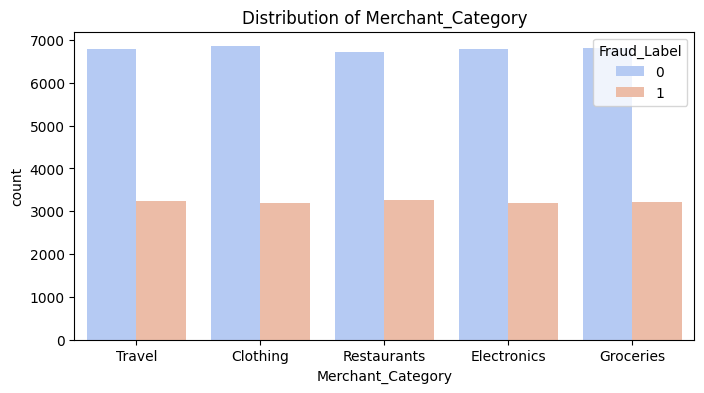

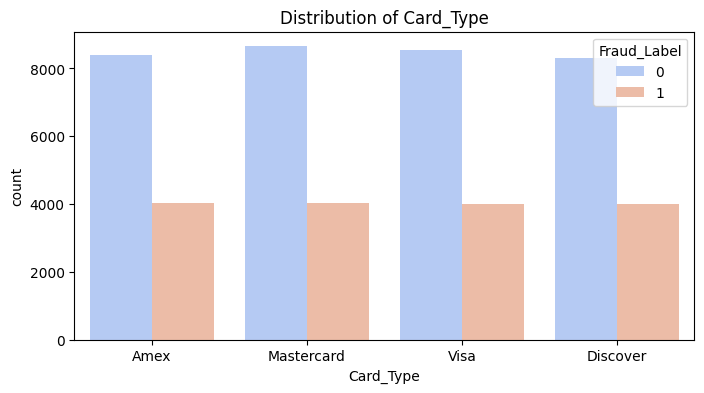

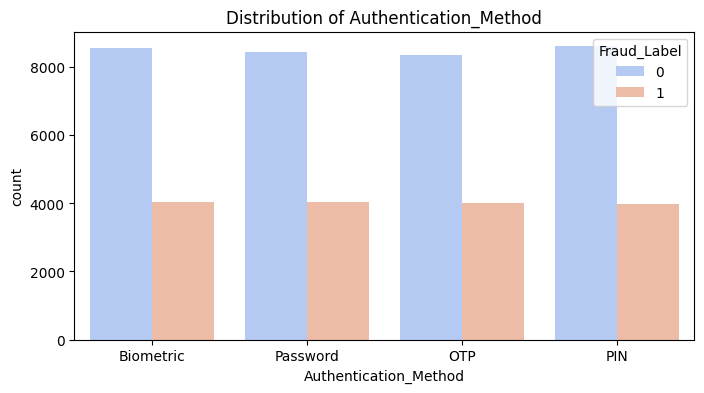

In [16]:
for col in cat_cols:
    plt.figure(figsize=(8,4))
    plt.title(f"Distribution of {col}")
    sns.countplot(x=col, data=df, hue=df['Fraud_Label'], palette='coolwarm')
    plt.show()

In [17]:
for col in cat_cols:
    print("*"*50)
    print(df[col].value_counts())

**************************************************
Transaction_Type
POS               12549
Online            12546
ATM Withdrawal    12453
Bank Transfer     12452
Name: count, dtype: int64
**************************************************
Device_Type
Tablet    16779
Mobile    16640
Laptop    16581
Name: count, dtype: int64
**************************************************
Location
Tokyo       10208
Mumbai       9994
London       9945
Sydney       9938
New York     9915
Name: count, dtype: int64
**************************************************
Merchant_Category
Clothing       10033
Groceries      10019
Travel         10015
Restaurants     9976
Electronics     9957
Name: count, dtype: int64
**************************************************
Card_Type
Mastercard    12693
Visa          12560
Amex          12419
Discover      12328
Name: count, dtype: int64
**************************************************
Authentication_Method
Biometric    12591
PIN          12586
Password     12457


# 📅 Timestamp Feature 📅

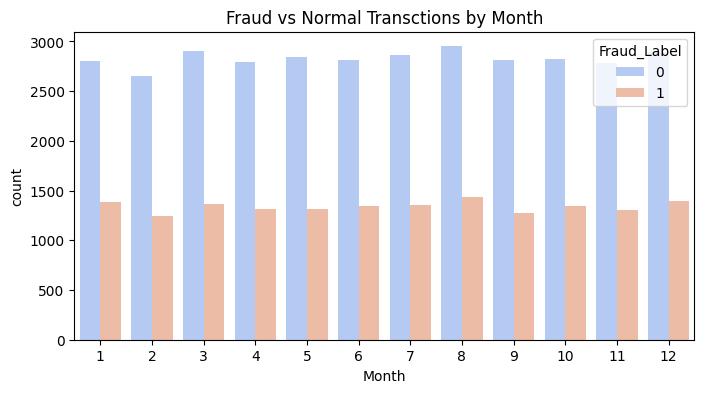

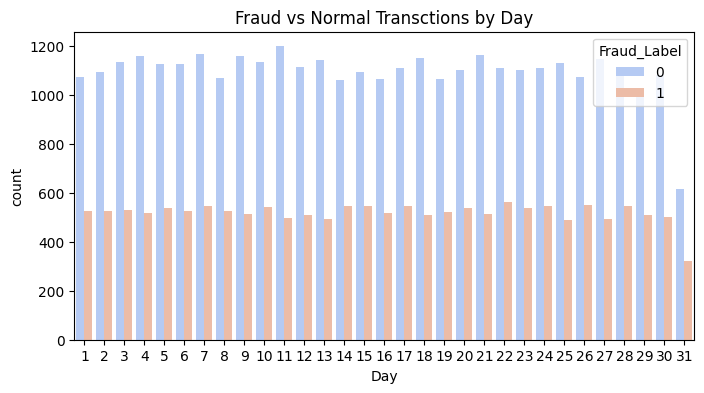

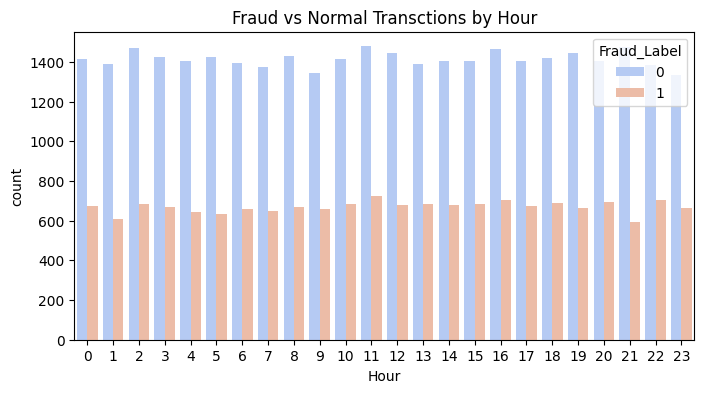

In [18]:
df['Timestamp_dt'] = pd.to_datetime(df['Timestamp'])
df['Month']=df['Timestamp_dt'].dt.month
df['Day']=df['Timestamp_dt'].dt.day
df['Hour']=df['Timestamp_dt'].dt.hour
date_cols=['Month','Day','Hour']
for col in date_cols:
    plt.figure(figsize=(8,4))
    plt.title(f"Fraud vs Normal Transctions by {col}")
    sns.countplot(x=col, data=df, hue=df['Fraud_Label'], palette='coolwarm')
    plt.show()
    

In [19]:
#cos and sin transformations 
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)
df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)

df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)


# 📊 Correlations Between Features 📊

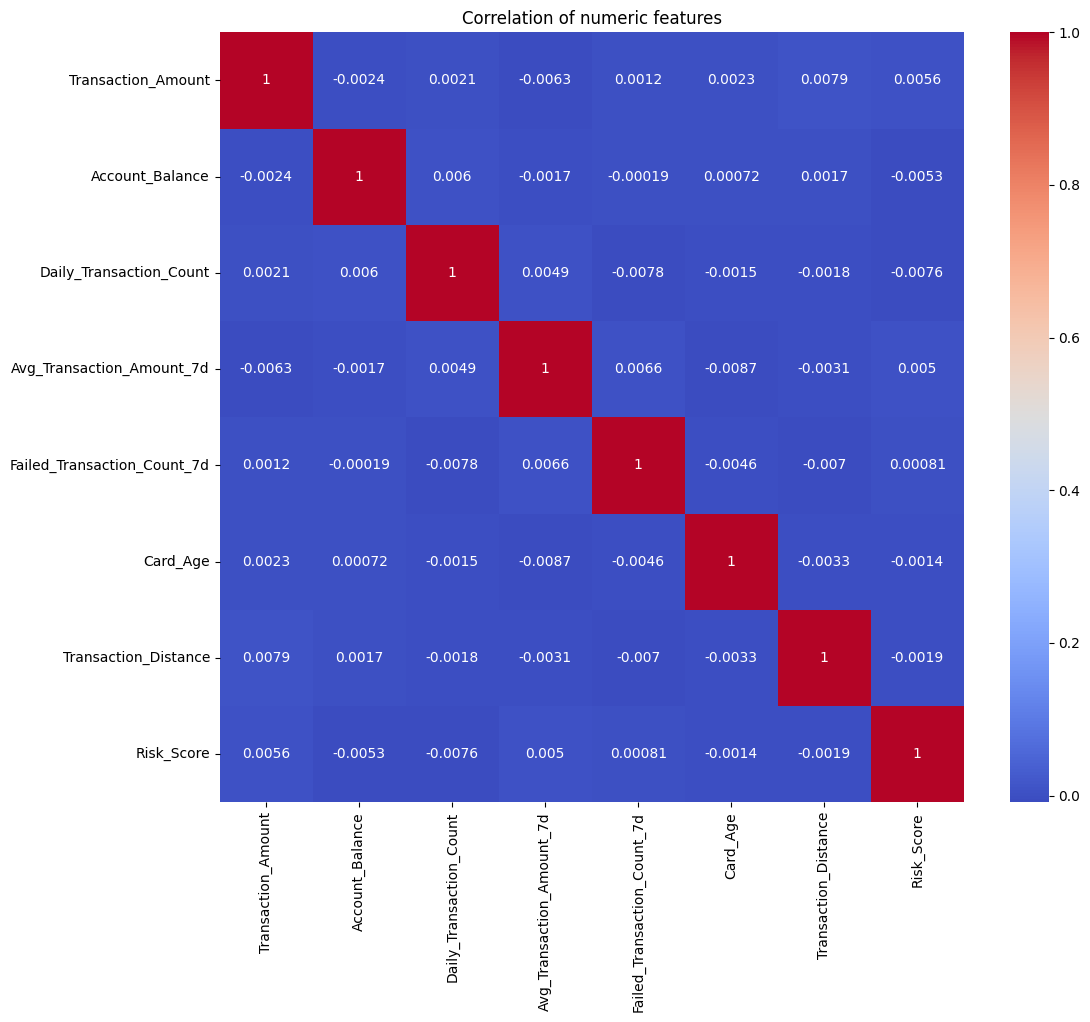

In [20]:
corr_matrix=df[num_cols].corr()
plt.figure(figsize=(12,10))
plt.title('Correlation of numeric features')
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.show()

#  ⚙️ Preprocessing ⚙️

In [21]:
target=df['Fraud_Label']

num_cols=['Transaction_Amount', 'Account_Balance',
          'Daily_Transaction_Count', 'Avg_Transaction_Amount_7d',
          'Failed_Transaction_Count_7d', 'Card_Age', 'Transaction_Distance',
          'Risk_Score', 'Month','Day', 'Hour']

num_cols_scaled=['Month_sin','Month_cos','Day_sin','Day_cos','Hour_sin','Hour_cos']

to_remove=['Transaction_ID', 'User_ID','Timestamp', 'Fraud_Label']#Fraud_Label, because it's target
df.drop(to_remove, axis=1, inplace=True)

In [22]:
num_pipeline=make_pipeline(FunctionTransformer(np.log1p), StandardScaler())
cat_pipeline=make_pipeline(OneHotEncoder(handle_unknown='ignore'))

preprocessing=ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])
preprocessing.fit(df)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<ufunc 'log1p'>)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Transaction_Amount', 'Account_Balance',
                                  'Daily_Transaction_Count',
                                  'Avg_Transaction_Amount_7d',
                                  'Failed_Transaction_Count_7d', 'Card_Age',
                                  'Transaction_Distance', 'Risk_Score', 'Month',
                                  'Day', 'Hour']),
                                ('cat',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Transaction_Type', 'Device_Type', 'Location',
                                  'Merchant_Category', 'Card_Type',
                                  'Authentication_Method'])])

#  📊 Splitting Data: Train & Test 📊

In [23]:
X_train,X_test,y_train,y_test=train_test_split(df, target, test_size=0.2)

# 🤖 Model Selection 🤖

In [24]:
def model_evaluation(y_true,y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Accuracy score: {acc:.4f}")
    print(f"F1 score: {f1:.4f}")
    cm=confusion_matrix(y_true,y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], 
                yticklabels=["Actual 0", "Actual 1"])
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

XGB
Accuracy score: 0.9997
F1 score: 0.9995


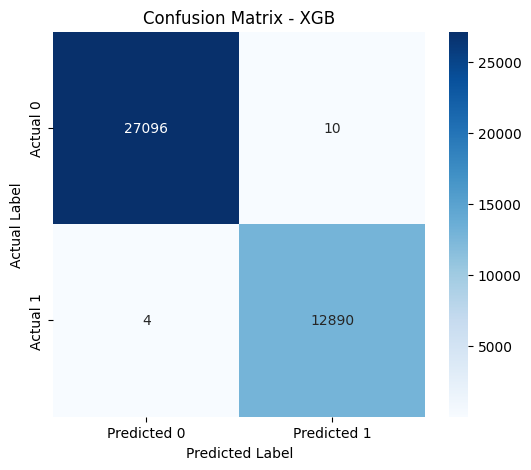

LightGBM
Accuracy score: 0.9986
F1 score: 0.9978


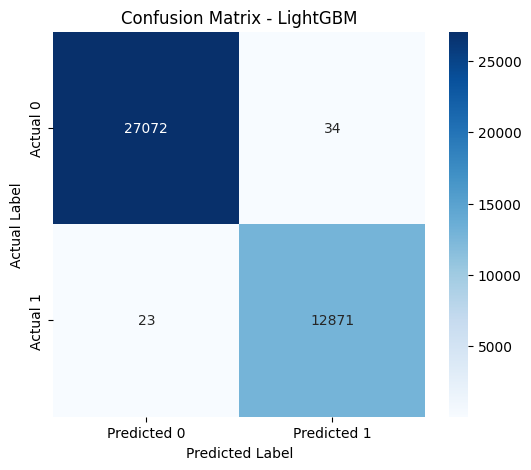

CatBoost
Accuracy score: 0.9996
F1 score: 0.9994


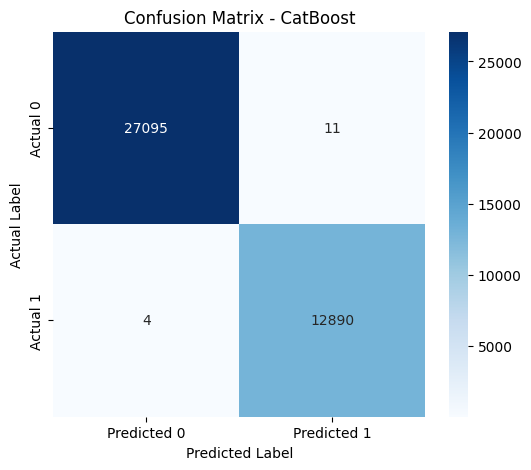

RandomForest
Accuracy score: 1.0000
F1 score: 1.0000


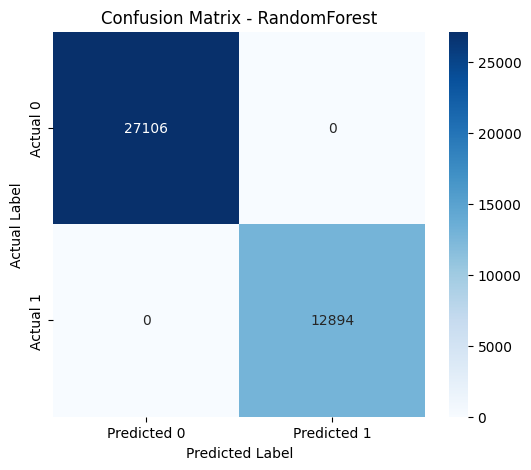

AdaBoost
Accuracy score: 1.0000
F1 score: 1.0000


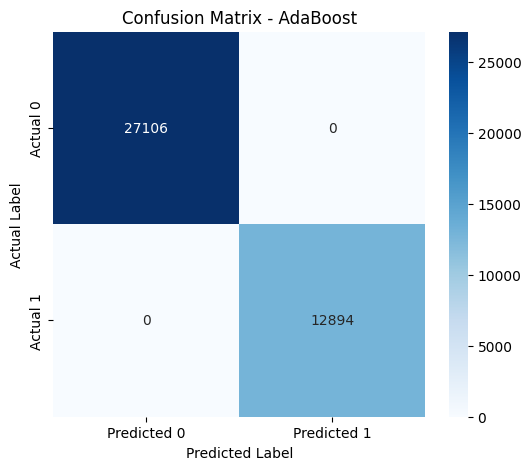

GradientBoosting
Accuracy score: 1.0000
F1 score: 1.0000


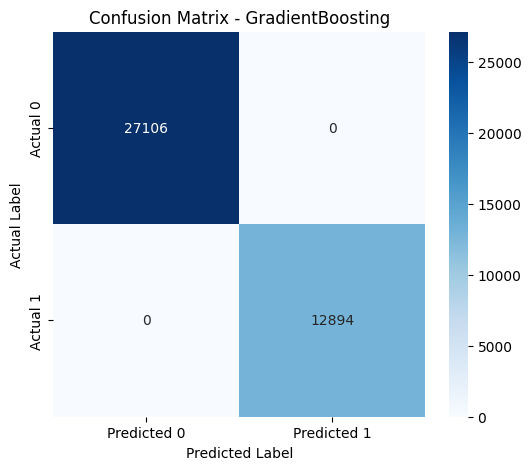

LogisticRegression
Accuracy score: 0.7733
F1 score: 0.6237


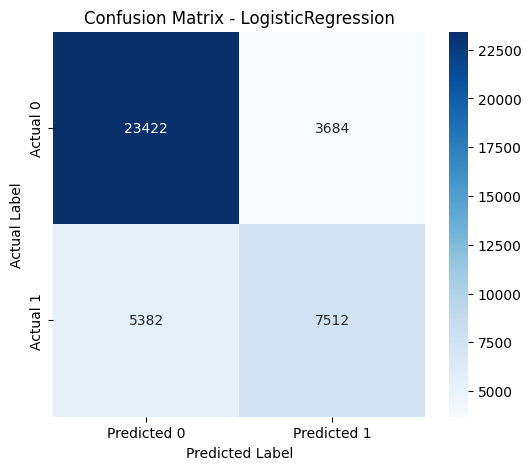

In [25]:
xgb_clf = XGBClassifier(verbosity=0)
lgbm_clf = LGBMClassifier(verbose=-1)
catboost_clf = CatBoostClassifier(verbose=0)
rf_clf = RandomForestClassifier()
adaboost_clf = AdaBoostClassifier()
gradient_clf = GradientBoostingClassifier(verbose=0)
logistic_reg = LogisticRegression()

estimators={
    'XGB':xgb_clf,
    'LightGBM': lgbm_clf,
    'CatBoost': catboost_clf,
    'RandomForest': rf_clf,
    'AdaBoost': adaboost_clf,
    'GradientBoosting': gradient_clf,
    'LogisticRegression': logistic_reg
}
models={}
for name, estimator in estimators.items():
    models[f'{name}']=make_pipeline(preprocessing, estimator)

for name, model in models.items():
    print(name)
    preds=cross_val_predict(model,X_train, y_train, cv=3)
    model_evaluation(y_train, preds, name)
    
    

# |🧪 Model Testing & Results 🧪
as we can see every model besides Logistic Regression achieved over 99% accuracy so let's check it on the test set

XGB
CPU times: user 1.23 s, sys: 10.5 ms, total: 1.24 s
Wall time: 381 ms
Accuracy score: 1.0000
F1 score: 1.0000


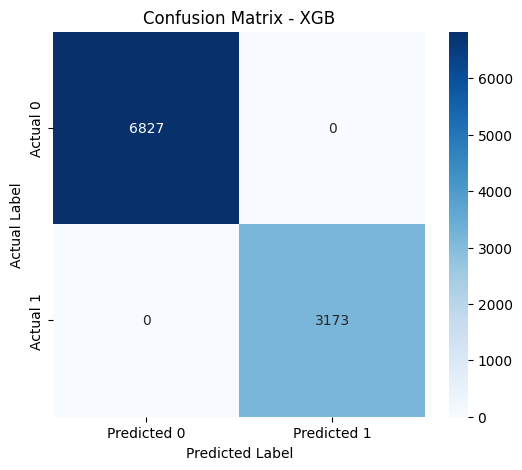

LightGBM
CPU times: user 715 ms, sys: 10 ms, total: 725 ms
Wall time: 417 ms
Accuracy score: 0.9987
F1 score: 0.9980


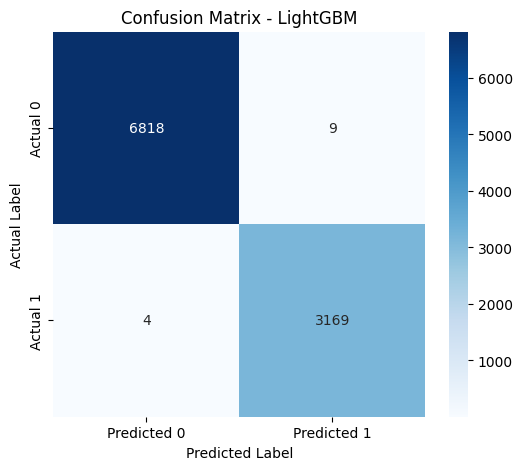

CatBoost
CPU times: user 25.5 s, sys: 2.61 s, total: 28.1 s
Wall time: 7.64 s
Accuracy score: 1.0000
F1 score: 1.0000


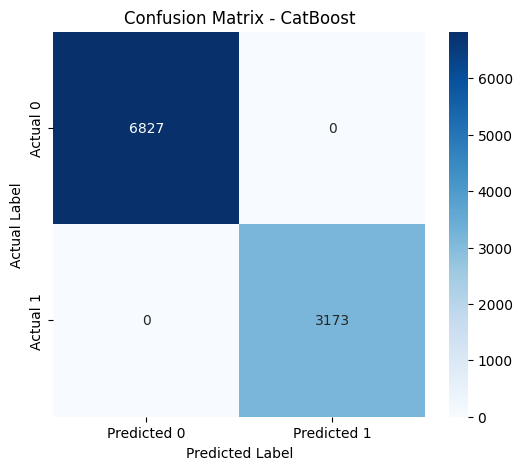

RandomForest
CPU times: user 5.4 s, sys: 5.65 ms, total: 5.4 s
Wall time: 5.37 s
Accuracy score: 1.0000
F1 score: 1.0000


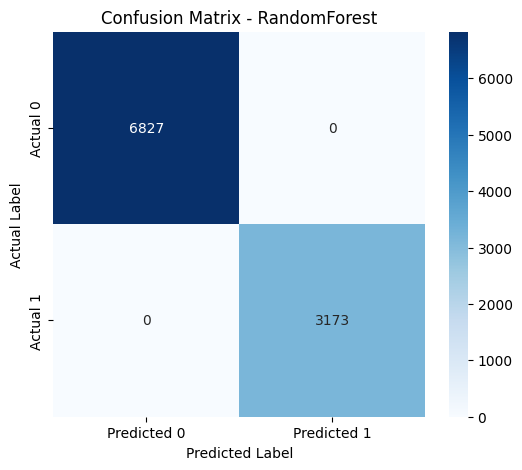

AdaBoost
CPU times: user 3.79 s, sys: 718 µs, total: 3.79 s
Wall time: 3.76 s
Accuracy score: 1.0000
F1 score: 1.0000


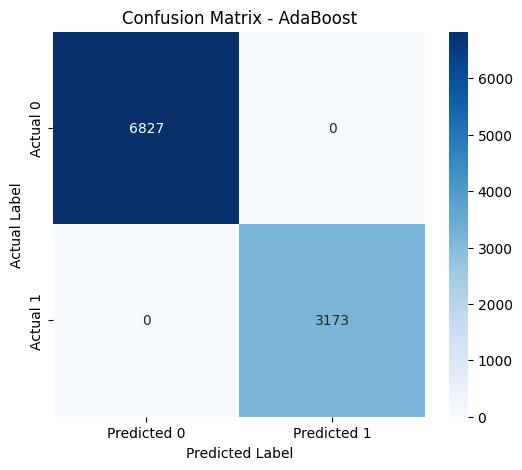

GradientBoosting
CPU times: user 10.8 s, sys: 2.43 ms, total: 10.8 s
Wall time: 10.8 s
Accuracy score: 1.0000
F1 score: 1.0000


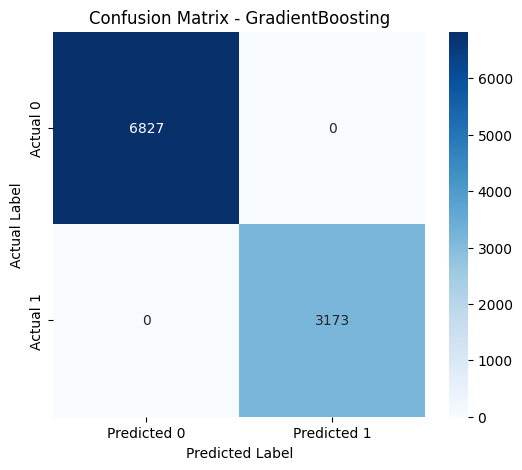

LogisticRegression
CPU times: user 262 ms, sys: 1.02 ms, total: 263 ms
Wall time: 165 ms
Accuracy score: 0.7775
F1 score: 0.6252


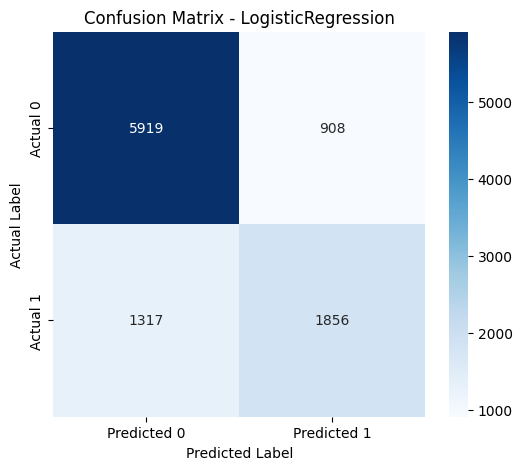

In [26]:
for name, model in models.items():
    print(name)
    %time model.fit(X_train,y_train)
    preds=model.predict(X_test)
    model_evaluation(y_test, preds, name)
    
    

# 📜 Summary 📜

✅ The dataset was clean with no missing values. <br>
📊 Categorical features were evenly distributed. <br>
🔍 No significant correlations were found between numerical features. <br>
🤖 All models, except Logistic Regression, achieved over 99% accuracy. <br>
🚀 Some models even reached 100% accuracy on the test set. <br>

# 🎉 Thank You for Your Attention! 🎉

Thank you for reviewing this notebook! I hope you found it insightful. 😊

💡 Feel free to leave your thoughts, feedback, or any tips for improvement.